In [1]:
import numpy as np
import pandas as pd

seed = 42
np.random.seed(seed)

In [2]:
df = pd.read_csv('../datasets/salary/Salary Data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  373 non-null    float64
 1   Gender               373 non-null    object 
 2   Education Level      373 non-null    object 
 3   Job Title            373 non-null    object 
 4   Years of Experience  373 non-null    float64
 5   Salary               373 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.7+ KB


In [4]:
df.sample(10, random_state=seed)

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
167,46.0,Male,PhD,Senior Researcher,18.0,150000.0
33,39.0,Female,Bachelor's,Marketing Specialist,10.0,65000.0
15,44.0,Male,Bachelor's,Operations Manager,16.0,125000.0
316,34.0,Female,Master's,Senior Financial Advisor,6.0,80000.0
57,43.0,Male,PhD,Senior Engineer,17.0,140000.0
291,49.0,Male,PhD,Director of Operations,21.0,180000.0
76,50.0,Female,Bachelor's,Operations Manager,22.0,160000.0
119,35.0,Male,Master's,Senior Product Manager,10.0,120000.0
280,31.0,Male,Bachelor's,Junior Operations Analyst,3.0,50000.0
126,37.0,Female,Master's,Senior HR Generalist,9.0,95000.0


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,373.0,37.431635,7.069073,23.0,31.0,36.0,44.0,53.0
Years of Experience,373.0,10.030831,6.557007,0.0,4.0,9.0,15.0,25.0
Salary,373.0,100577.345845,48240.013482,350.0,55000.0,95000.0,140000.0,250000.0


In [6]:
df.describe(exclude='number').T

,count,unique,top,freq
Gender,373,2,Male,194
Education Level,373,3,Bachelor's,224
Job Title,373,174,Director of Marketing,12


### Data Preprocessing

- Check null values
- Check for duplicates
- Check for inconsistencies

In [7]:
df.isna().sum()

Age                    2
Gender                 2
Education Level        2
Job Title              2
Years of Experience    2
Salary                 2
dtype: int64

In [8]:
print('total missing values:', df.isna().sum().sum())

total missing values: 12


In [9]:
# look at rows where we have null values
df[df["Age"].isna()]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
172,NaN,NaN,NaN,NaN,NaN,NaN
260,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# we shall drop the two rows, since they are full of nulls
df.dropna(subset=['Age'], inplace=True)

In [11]:
# no null values should be found now, since the NaN were all in these two rows
df.isna().sum()

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

In [12]:
# Check for duplicates
df.duplicated().sum()

49

In [13]:
# No reason to keep duplicates. Let's drop them
df.drop_duplicates(inplace=True)

Reset the index after all the dropping

In [14]:
# We need to reset our index after all the dropping
df.reset_index(inplace=True, drop=True)

Let's Ask Some Questions and Get Spectacular Insights

- What is the average salary for each gender?
- I am wondering if the education level has an influence on the salary or not
- Does years of experience influence the salary?


Let's build the Model and train it

In [56]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [27]:
X = df.drop('Salary', axis=1)
Y = df['Salary']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [30]:
x_train.head()

,Age,Gender,Education Level,Job Title,Years of Experience
73,28.0,Male,Bachelor's,Technical Support Specialist,2.0
181,44.0,Female,PhD,Senior UX Designer,15.0
17,39.0,Male,PhD,Senior Engineer,12.0
24,41.0,Male,Master's,Financial Manager,13.0
146,42.0,Female,PhD,Senior Data Scientist,16.0


In [31]:
y_train.head()

73      40000.0
181    145000.0
17     115000.0
24     140000.0
146    150000.0
Name: Salary, dtype: float64

In [32]:
numeric_features = ["Age", "Years of Experience"]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())]
)

categorical_features = ["Gender", "Education Level", "Job Title"]
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mode')),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [33]:
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression()),
    ]
)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age',
                                                   'Years of Experience']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Education Level',
                                                   'Job Title'])])),
                ('regressor', LinearRegression())])

In [35]:
model.fit(x_train, y_train);

In [76]:
y_test.shape

(65,)

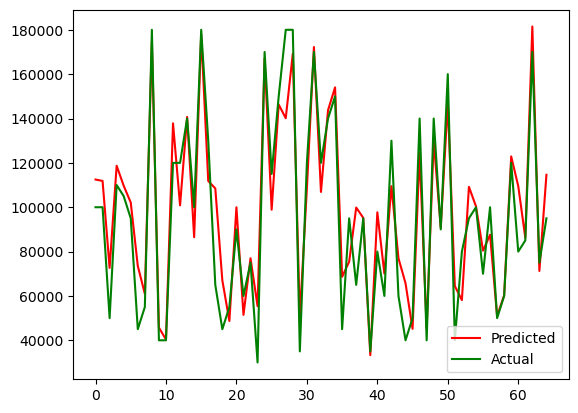

In [86]:
y_pred = model.predict(x_test)

# plot the difference between the actual and predicted values
import matplotlib.pyplot as plt

plt.plot(range(len(y_pred)), y_pred, label='Predicted', c='red')
plt.plot(range(len(y_test)), y_test, label='Actual', c='green')
plt.legend()
plt.show()

In [78]:
model.score(x_test, y_test) # R^2

0.8670436996986352

In [80]:
metrics = {
    'R2': r2_score(y_test, model.predict(x_test)),
    'RMSE': root_mean_squared_error(y_test, model.predict(x_test))
}
metrics

{'R2': 0.8670436996986352, 'RMSE': 15851.154075254091}